In [22]:
import torch
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from torchvision import transforms

In [101]:
class Encoder(nn.Module):
    def __init__(self, latent_dim) -> None:
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 0),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*6*6, self.latent_dim),
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim) -> None:
        super().__init__()

        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64*6*6),
            nn.ReLU(),
            nn.Unflatten(1, (64, 6, 6)),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [110]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = MNIST(root='.', train=True, download=True, transform=transform)
test_data = MNIST(root='.', train=False, download=True, transform=transform)
valid_test, test_data = torch.utils.data.random_split(test_data, [5000, 5000])

In [111]:
batch_size = 1024
optimizer = optim.Adam
criterion = nn.MSELoss()
latent_dim = 128
learning_rate = 1e-3

In [112]:
# setting seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [113]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_test, batch_size=batch_size, shuffle=False)

In [114]:
def display_image(img1, img2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')
    plt.show()

In [117]:
def trainer(encoder, decoder, train_loader, valid_loader, optimizer, criterion, lr, epochs=10):
    encoder = encoder.to('cuda')
    decoder = decoder.to('cuda')
    optimizer = optimizer(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        for i, (x, _) in enumerate(train_loader):
            x = x.to('cuda')
            optimizer.zero_grad()
            # print(x[0])
            z = encoder(x)
            x_hat = decoder(z)
            # print(x_hat[0])
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}')
        encoder.eval()
        decoder.eval()
        if epoch % 5 == 0:
            with torch.no_grad():
                total_loss = 0
                for i, (x, _) in enumerate(valid_loader):
                    x = x.to('cuda')
                    z = encoder(x)
                    x_hat = decoder(z)
                    loss = criterion(x_hat, x)
                    display_image(x[0].squeeze().cpu().numpy(), x_hat[0].squeeze().cpu().numpy())
                    total_loss += loss.item()
                print(f'Epoch: {epoch}, Test Loss: {total_loss/len(valid_loader)}')

Epoch: 0, Iteration: 0, Loss: 0.2599234879016876


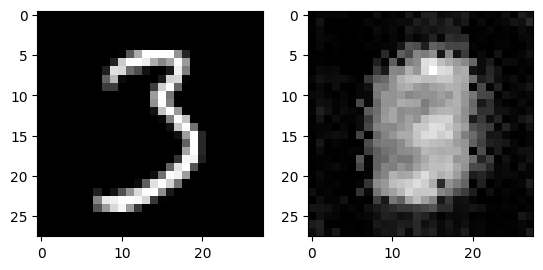

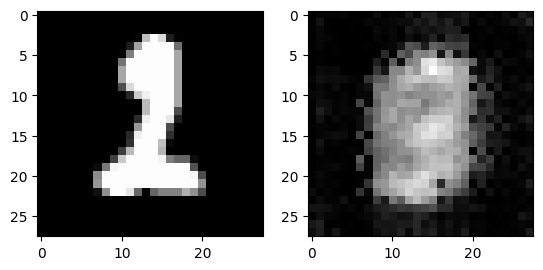

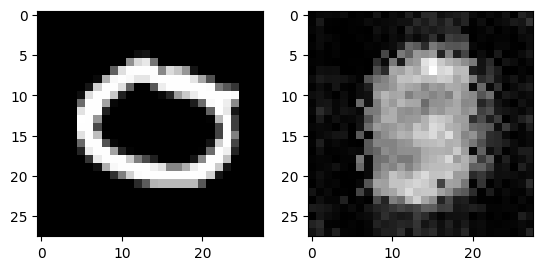

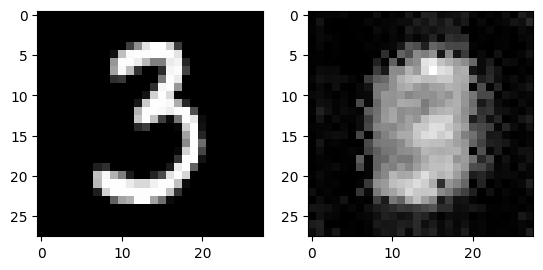

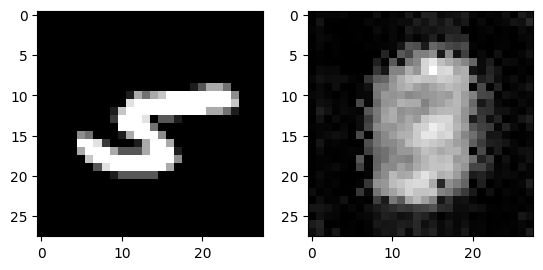

Epoch: 0, Test Loss: 0.06796775013208389
Epoch: 1, Iteration: 0, Loss: 0.06883807480335236
Epoch: 2, Iteration: 0, Loss: 0.030415423214435577
Epoch: 3, Iteration: 0, Loss: 0.014738629572093487
Epoch: 4, Iteration: 0, Loss: 0.010252682492136955
Epoch: 5, Iteration: 0, Loss: 0.00795457512140274


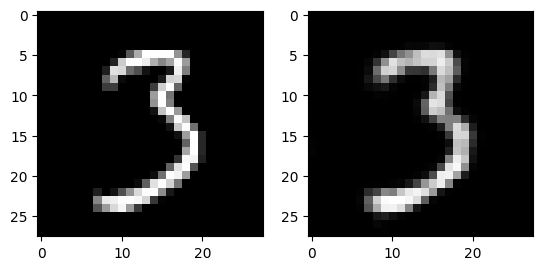

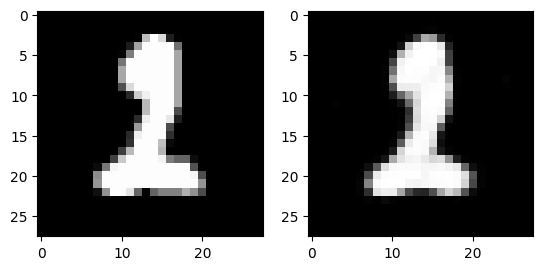

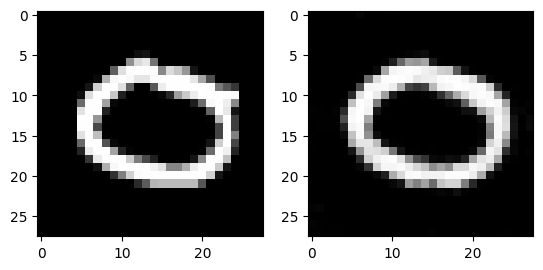

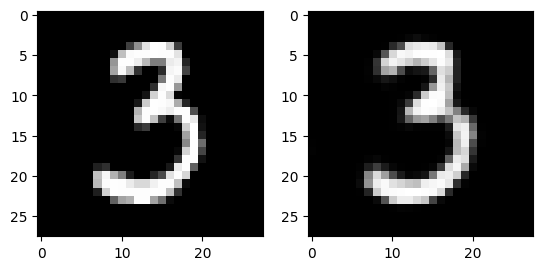

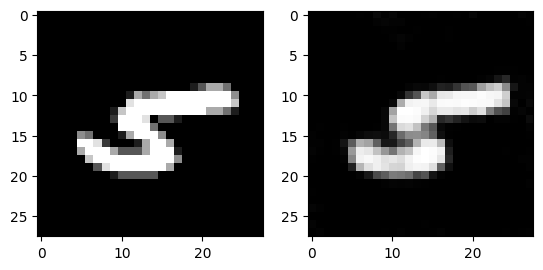

Epoch: 5, Test Loss: 0.006456724833697081
Epoch: 6, Iteration: 0, Loss: 0.00683347275480628
Epoch: 7, Iteration: 0, Loss: 0.005912309046834707
Epoch: 8, Iteration: 0, Loss: 0.0052297296933829784
Epoch: 9, Iteration: 0, Loss: 0.004697679542005062


In [118]:
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)

trainer(encoder, decoder, train_loader, valid_loader, optimizer, criterion, learning_rate, epochs=10)

In [139]:
def generate_image(decoder, latent_dim):
    random_img = decoder(latent_dim).squeeze().cpu().detach().numpy()
    plt.imshow(random_img, cmap='gray')
    plt.show()

In [142]:
label1_data = train_data.data[train_data.targets == 1]
label1_data = label1_data.unsqueeze(1).float()
label1_loader = DataLoader(label1_data, batch_size=batch_size, shuffle=True)

In [150]:
encoded_images = []
label = 1
for i, (x) in enumerate(label1_loader):
    x = x.to('cuda')
    z = encoder(x)
    encoded_images.append(z.cpu().detach().numpy())

In [151]:
encoded_images = np.concatenate(encoded_images, axis=0)

In [152]:
encoded_images.shape

(6742, 128)

In [156]:
mean_z = np.mean(encoded_images, axis=0)
variance_z = np.var(encoded_images, axis=0)

In [157]:
variance_z

array([ 214272.19 ,  604478.4  ,  221014.67 , 1470028.1  ,  877405.94 ,
        108318.414,  491380.16 ,  205478.22 ,   58071.48 ,  147519.2  ,
        139180.67 ,  359027.3  ,  447801.78 ,  193833.4  ,  609795.6  ,
        475894.16 ,  505137.06 ,  796994.4  ,  334186.   , 1322151.1  ,
        416303.2  ,  841841.94 ,  303188.1  , 1028815.9  ,  335466.22 ,
        378583.03 , 1106031.1  ,  300276.94 ,  397759.1  ,  146259.66 ,
        777877.1  ,  508150.6  ,  356675.25 ,  269579.62 ,  610169.2  ,
         97595.95 ,  559543.25 ,  259296.31 , 1341492.2  ,  124523.22 ,
        184737.72 ,  838279.9  ,  134277.9  ,  262988.6  ,  170338.   ,
        750259.1  ,  190564.12 ,  227587.08 ,  449513.97 ,  136303.33 ,
        184718.27 ,  223544.61 ,  357771.66 ,  146252.6  ,  268415.5  ,
        232531.89 ,  125699.96 ,  494012.78 ,  180017.38 ,  452095.97 ,
        590125.06 ,  508997.38 ,  227703.   ,  411862.1  ,  712331.56 ,
        169687.84 ,  581167.7  ,  789956.4  , 1258004.6  ,   472

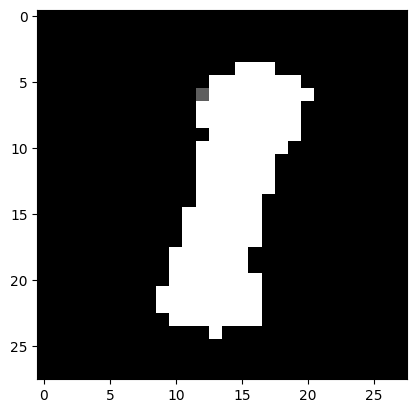

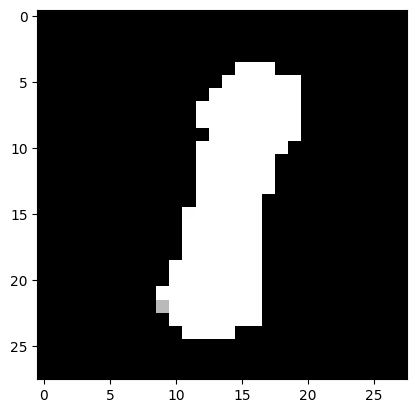

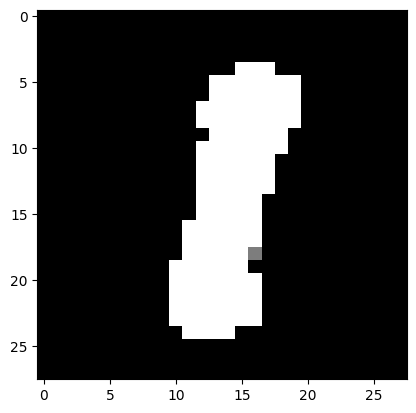

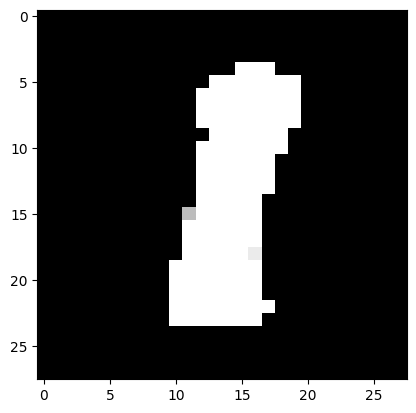

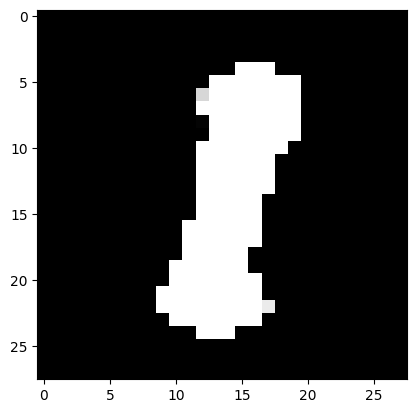

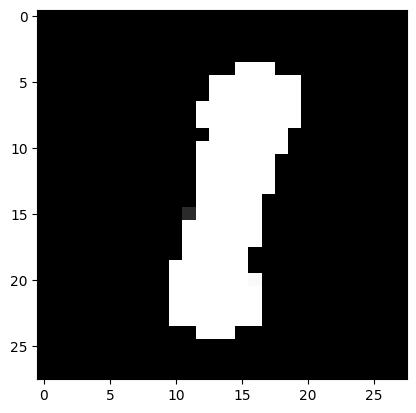

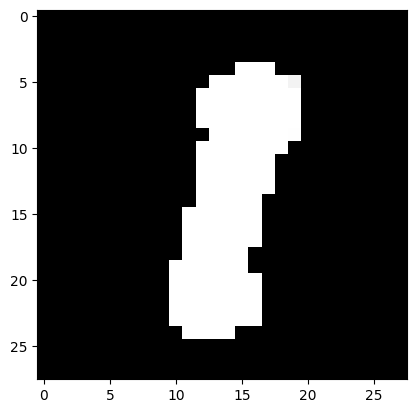

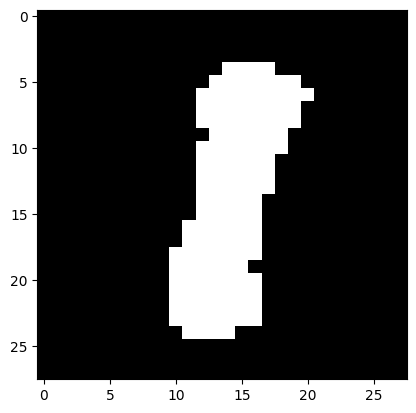

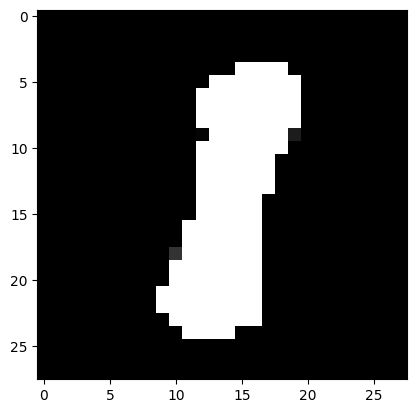

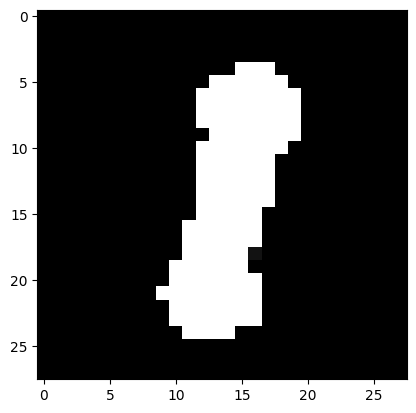

In [154]:
for i in range(10):
    latent_dim = np.random.normal(mean_z, variance_z)
    latent_dim = torch.tensor(latent_dim).float().to('cuda')
    latent_dim = latent_dim.unsqueeze(0)
    generate_image(decoder, latent_dim)